# Reto 3 - Implementación de un control difuso para el control de velocidad de un robot

# Integrantes

Esteban Padilla Cerdio A01703068

Andrea González Arredondo A01351820         

Naomi Estefanía Nieto Vega A01706095

Karen Cebreros López A01704254

Aranza Leal Aguirre A01751706

## Resumen

En esta actividad, se implementará un controlador difuso para regular la velocidad de un robot móvil simulado con ROS, utilizando dos sensores como entradas. Se comparará el comportamiento del controlador difuso Mamdani con un controlador TSK, y se analizarán diferentes configuraciones de controladores difusos para determinar cuál es el mejor modelo final. Además, se diseñarán funciones de pertenencia y se establecerán reglas para ambos controladores. Se utilizarán las librería SKFuzzy y FuzzyLite para la implementación de los controladores. El objetivo de esta actividad es analizar el proceso de diseño y comparación de diferentes modelos de controladores difusos, y no solo las comparativas numéricas.

Los modelos a comparar son:

* Mamdani con funciones de pertenencia triangulares y desdifusificación de centroide
* Mamdani con funciones de pertenencia gausianas y desdifusificación de centroide
* Mamdani con funciones de pertenencia gausianas y desdifusificación de MOM
* TSK con funciones de pertenencia triangulares y sin desdifusificación

## Introducción

El control difuso es una forma ampliamente utilizada en la industria para manejar sistemas complejos de forma más intuitiva, relacionando valores de control con variables lingüísticas, fáciles de identificar para un ser humano. Podemos encontrar controladores de este tipo en el control de procesos industriales, la robótica, la navegación autónoma, el control de tráfico y la automatización de sistemas de producción. Unas de las implementaciones más populares de la teoría difusa son los controladores Mamdani y TSK, los cuales utilizan reglas para generar salidas "borrosas", en lugar de simplemente binarias o numéricas como haría un controlador tradicional.

Los controladores difusos Mandani y TSK tienen algunas diferencias clave en su enfoque y funcionamiento. Los controladores tipo Mandani utilizan reglas lingüísticas difusas para modelar el comportamiento del sistema, mientras que los controladores TSK utilizan una combinación de reglas lingüísticas y modelos matemáticos precisos para lograr un control más exacto.

Por medio de distintas funciones de pertenencia y métodos de desdifusificación, es posible obtener una gran variedad de controladores, cada uno con sus ventajas y desventajas. El siguiente reporte explora dichas combinaciones, con el objetivo de identificar las características de cada una para implementar un controlador de velocidad para un robot con ROS, a partir de lecturas de encoders y un semáforo.


## Descripción del controlador difuso

In [54]:
import fuzzylite as fl
from skfuzzy import control as sk
import skfuzzy as fuzz
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [55]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import matplotlib.pyplot as plt


def plot_surface(vel):
	upsampled = np.linspace(0, 170, 170)
	x, y = np.meshgrid(upsampled, upsampled)
	z = np.zeros_like(y)

	for i in range(170):
		for j in range(120):
			vel.input['Encoder'] = i
			vel.input['Camera'] = j
			vel.compute()
			z[i, j] = vel.output['RPM']

	# Plot the result in pretty 3D with alpha blending

	fig = plt.figure(figsize=(8, 8))
	ax = fig.add_subplot(111, projection='3d')

	surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
						linewidth=0.4, antialiased=True)
	ax.set_xlabel('Encoder')
	ax.set_ylabel('Camera')
	ax.set_zlabel('RPM')

	cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
	cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
	cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

	ax.view_init(30, 200)


Comenzamos agregando las entradas del sensor de velocidad de las ruedas y el color detectado por la cámara. Igualmente, inicializamos la salida, que será la velocidad que se le enviará al controlador de velocidad del robot.

In [56]:
encoder = sk.Antecedent(np.arange(0, 170, 1), 'Encoder')
camera = sk.Antecedent(np.arange(0, 120, 1), 'Camera')
rpm = sk.Consequent(np.arange(0, 170, 1), 'RPM')


### Triangular

Las funciones de pertenencia que se crearon son las siguientes:

Para la velocidad detectada por el encoder, tenemos cuatro valores de nuestra variable semántica: la velocidad nula, velocidad baja, velocidad media y velocidad alta. La velocidad nula es un área pequeña comprendida del 0 al 5 RPM. Esto es porque, si le damos un único espacio de 0RPM, en lugar de un área, es difícil que el controlador llegue al valor correcto cuando se desea detener al robot. Para las demás áreas de velocidad, se dividió el dominio de velocidades del robot, que van de 0 a 170RPM, en tres partes iguales.

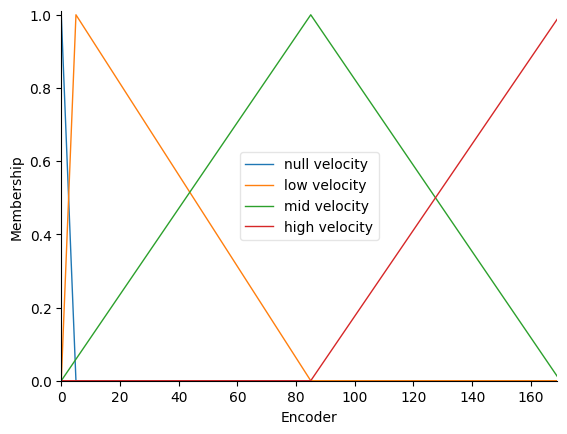

In [57]:
# Custom membership functions for encoder sensor
encoder['null velocity'] = fuzz.trimf(encoder.universe, [0, 0, 5])
encoder['low velocity'] = fuzz.trimf(encoder.universe, [0, 5, 85])
encoder['mid velocity'] = fuzz.trimf(encoder.universe, [0, 85, 170])
encoder['high velocity'] = fuzz.trimf(encoder.universe, [85, 170, 170])

encoder.view()


Para los valores de color detectados por la cámara, se dividió el dominio de datos igualmente en tres partes iguales. En este caso, los valores numéricos van de 0 a 120, correspondientes a la rueda de colores utilizadas en el formato HSV, donde el rojo se encuentra en 0°, el amarillo en 60° y el verde en 120°. Por lo tanto, las funciones de pertenencia siguen dichos valores.

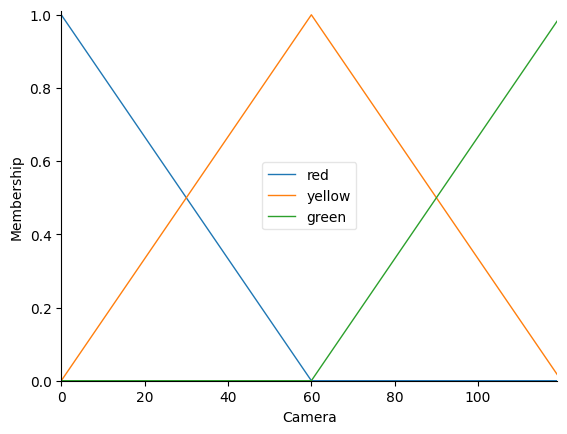

In [58]:
camera['red'] = fuzz.trimf(camera.universe, [0, 0, 60])
camera['yellow'] = fuzz.trimf(camera.universe, [0, 60, 120])
camera['green'] = fuzz.trimf(camera.universe, [60, 120, 120])

camera.view()


Para la salida, al estarse trabajando igualmente con la velocidad del robot, las funciones de pertenencia son iguales a aquellas designadas para la entrada.

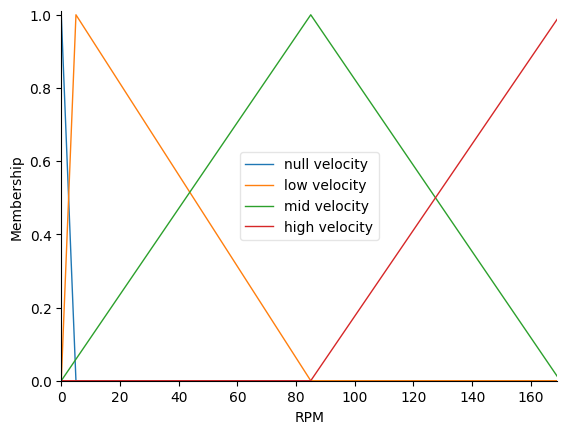

In [59]:

rpm['null velocity'] = fuzz.trimf(rpm.universe, [0, 0, 5])
rpm['low velocity'] = fuzz.trimf(rpm.universe, [0, 5, 85])
rpm['mid velocity'] = fuzz.trimf(rpm.universe, [0, 85, 170])
rpm['high velocity'] = fuzz.trimf(rpm.universe, [85, 170, 170])

rpm.view()


#### Reglas

Para las reglas, se tomaron en cuenta todas las posibles combinaciones entre las cuatro posibles velocidades de las ruedas y los tres colores del semáforo. Las reglas siguen las siguientes ideas:

* Si el semáforo está en rojo, reducir la velocidad hasta llegar a detenerse completamente. E.g. si la velocidad es media, bajarla a baja, y de ahí a detenido.
* Si el semáforo está en amarillo, reducir la velocidad lo más posible. E.g. si la velocidad es alta, llevarla hasta velocidad baja.
* Si el semáforo está en verde, ir aumentando la velocidad hasta llegar a la máxima. E.g. si la velocidad es nula, avanzar lentamente, luego medianamente rápido y finalmente lo más rápido posible.

In [60]:
null_red = sk.Rule(encoder['null velocity'] &
                   camera['red'], rpm['null velocity'])
null_yellow = sk.Rule(encoder['null velocity'] &
                      camera['yellow'], rpm['null velocity'])
null_green = sk.Rule(encoder['null velocity'] &
                     camera['green'], rpm['low velocity'])

low_red = sk.Rule(encoder['low velocity'] &
                  camera['red'], rpm['low velocity'])
low_yellow = sk.Rule(encoder['low velocity'] &
                     camera['yellow'], rpm['low velocity'])
low_green = sk.Rule(encoder['low velocity'] &
                    camera['green'], rpm['mid velocity'])

mid_red = sk.Rule(encoder['mid velocity'] &
                  camera['red'], rpm['low velocity'])
mid_yellow = sk.Rule(encoder['mid velocity'] &
                     camera['yellow'], rpm['low velocity'])
mid_green = sk.Rule(encoder['mid velocity'] &
                    camera['green'], rpm['high velocity'])

high_red = sk.Rule(encoder['high velocity'] &
                   camera['red'], rpm['mid velocity'])
high_yellow = sk.Rule(encoder['high velocity'] &
                      camera['yellow'], rpm['mid velocity'])
high_green = sk.Rule(encoder['high velocity'] &
                     camera['green'], rpm['high velocity'])


In [61]:
vel_ctrl = sk.ControlSystem([null_red, null_yellow, null_green, low_red, low_yellow, low_green,
                            mid_red, mid_yellow, mid_green, high_red, high_yellow, high_green])  # The inference blockq
vel = sk.ControlSystemSimulation(vel_ctrl)  # The whole Fuzzy Inference system

#### Prueba 1

Entrada: Robot detenido y semáforo en rojo<br>
Salida esperada: Robot detenido

1.6666666666666665


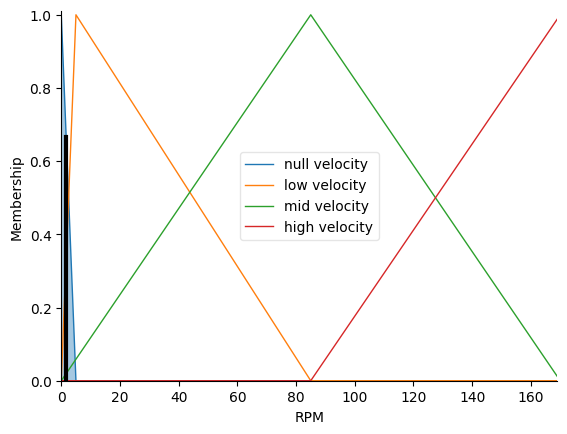

In [62]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 2

Entrada: Robot lento y semáforo en rojo<br>
Salida esperada: Robot detenido

31.86011904761904


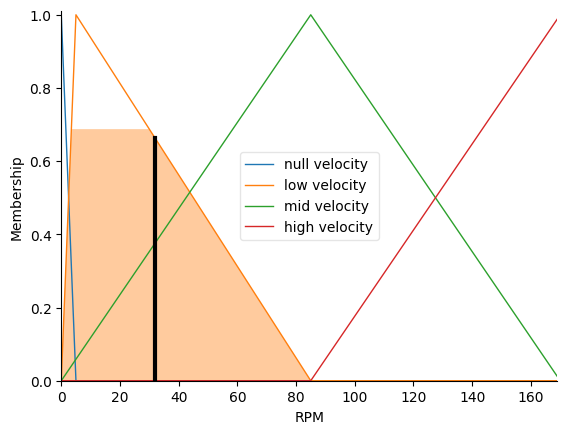

In [63]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 3

Entrada: Robot a velocidad media y semáforo en rojo<br>
Salida esperada: Velocidad baja, tendiendo a detenido

40.08156341347362


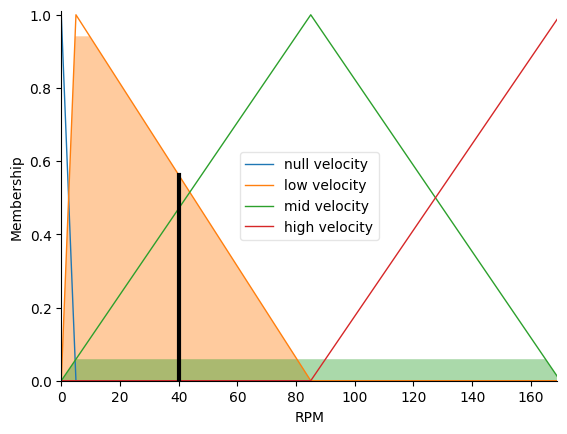

In [64]:
vel.input['Encoder'] = 90
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 4

Entrada: Robot rápido y semáforo en rojo<br>
Salida esperada: Velocidad media, tendiendo a detenido

82.90189614659704


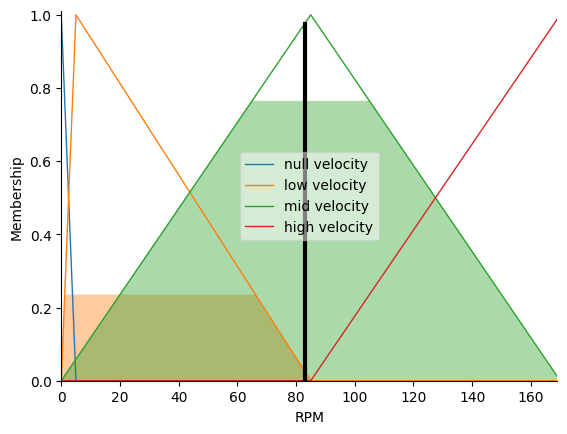

In [65]:
vel.input['Encoder'] = 150
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 5

Entrada: Robot detenido y semáforo en amarillo<br>
Salida esperada: Robot detenido

1.6666666666666665


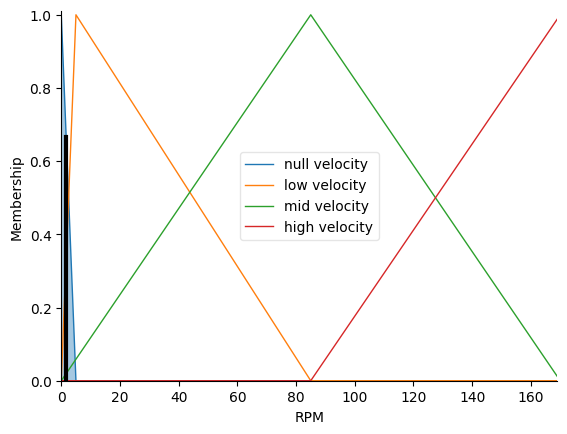

In [66]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 6

Entrada: Robot lento y semáforo en amarillo<br>
Salida esperada: Robot lento

31.86011904761904


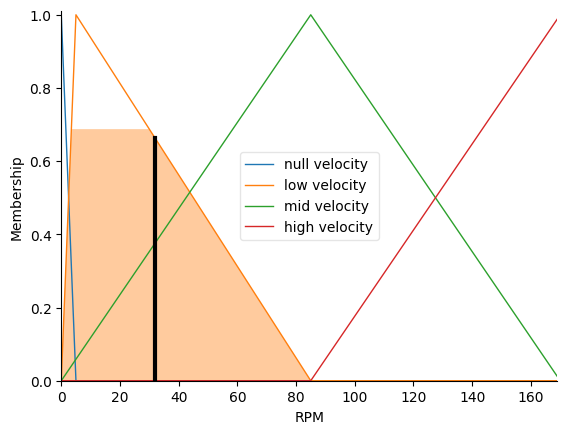

In [67]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 7

Entrada: Robot a velocidad media y semáforo en amarillo<br>
Salida esperada: Velocidad tendiendo a lenta

40.08156341347362


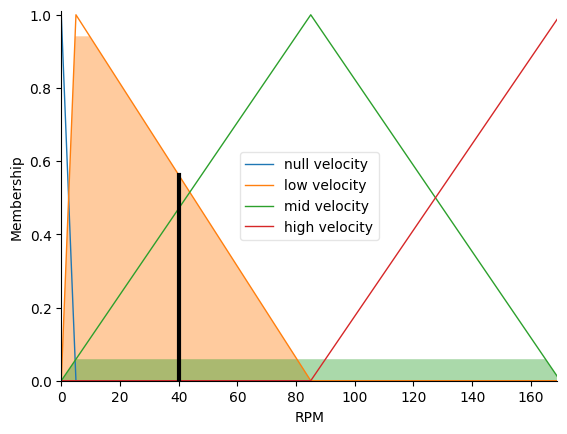

In [68]:
vel.input['Encoder'] = 90
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 8

Entrada: Robot rápido y semáforo en amarillo<br>
Salida esperada: Velocidad tendiendo a media

82.90189614659704


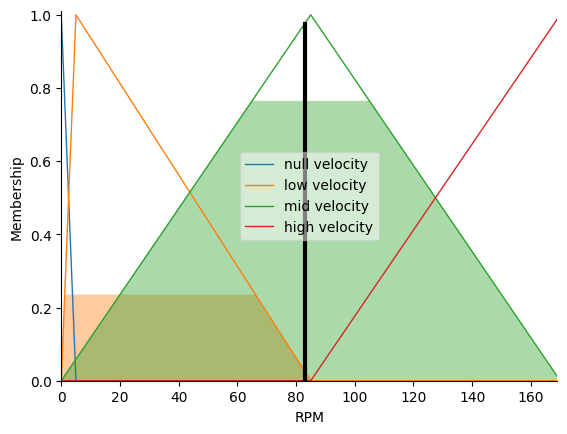

In [69]:
vel.input['Encoder'] = 150
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 9

Entrada: Robot detenido y semáforo en verde<br>
Salida esperada: Robot acelerando a velocidad media

30.534328525103426


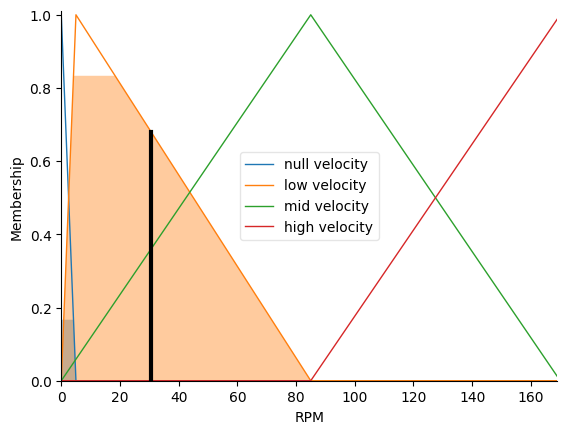

In [70]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 110

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 10

Entrada: Robot lento y semáforo en verde<br>
Salida esperada: Robot acelerando a velocidad media

88.36291121783954


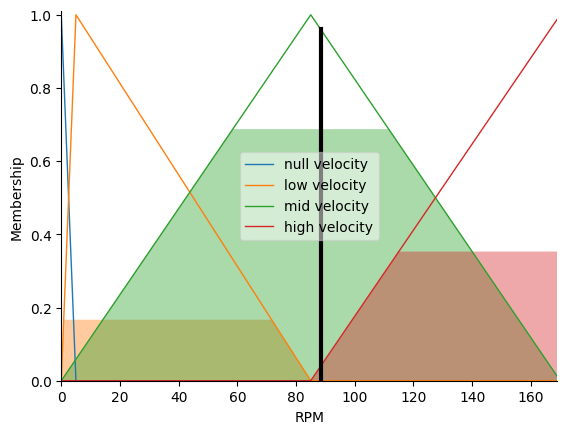

In [71]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 110

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


### Superficie de control

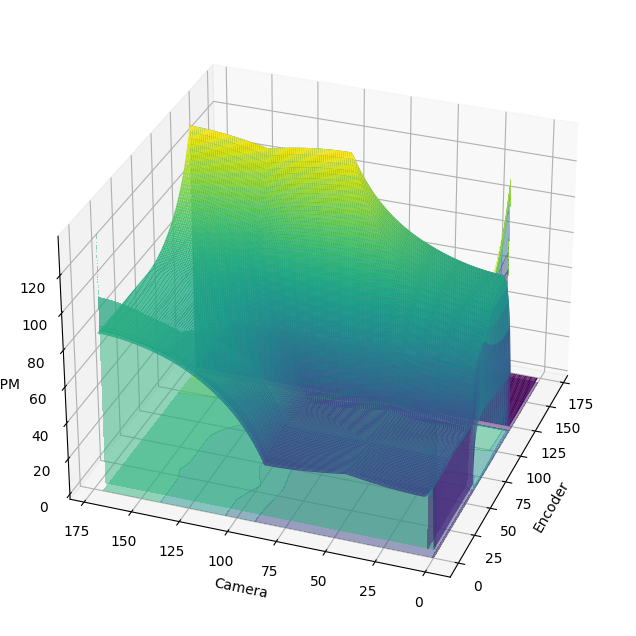

In [72]:
plot_surface(vel)

Podemos observar en esta superficie cómo la velocidad resultante tiende hacia abajo conforme el color del semáforo se dirige hacia el rojo (0°). Sin embargo, el valor nunca llega a cero, incluso si el semáforo está completamente en rojo. Esto significa que con este tipo de controlador no podremos llegar a detener nuestro robot por completo, sino que solamente tenderá a velocidades bajas. Por otro lado, se observa que el cambio entre un valor y otro es suave, por lo que si lo que queremos lograr es un cambio de velocidades ligero para los motores, esta sería una buena implementación.

### Gausiano

Ahora, realizaremos el mismo proceso pero con funciones de pertenencia gausianas. Los dominios de valores y las puntas de las MF permanecerán iguales. La diferencia será que ahora, en lugar de tener tres puntos para la función, tendremos solamente dos: uno para el centro de la campana, y uno para la desviación, a la cual le hemos asignado un valor de 1/4 del dominio total.

In [73]:
encoder['null velocity'] = fuzz.gaussmf(encoder.universe, 0, 5)
encoder['low velocity'] = fuzz.gaussmf(encoder.universe, 0, 42.5)
encoder['mid velocity'] = fuzz.gaussmf(encoder.universe, 85, 42.5)
encoder['high velocity'] = fuzz.gaussmf(encoder.universe, 170, 42.5)

# Custom membership functions for camera
camera['red'] = fuzz.gaussmf(camera.universe, 0, 30)
camera['yellow'] = fuzz.gaussmf(camera.universe, 60, 30)
camera['green'] = fuzz.gaussmf(camera.universe, 120, 30)

rpm['null velocity'] = fuzz.gaussmf(encoder.universe, 0, 5)
rpm['low velocity'] = fuzz.gaussmf(encoder.universe, 0, 42.5)
rpm['mid velocity'] = fuzz.gaussmf(encoder.universe, 85, 42.5)
rpm['high velocity'] = fuzz.gaussmf(encoder.universe, 170, 42.5)


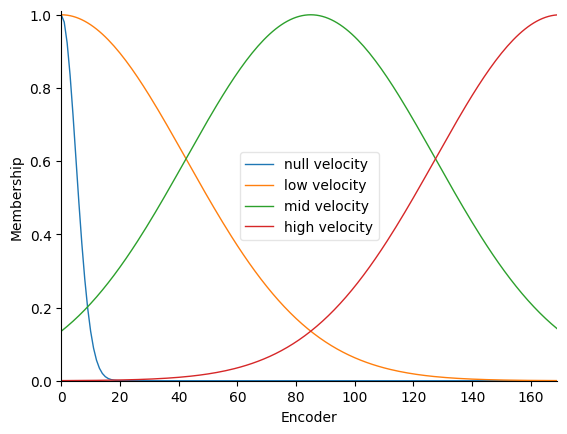

In [74]:
encoder.view()

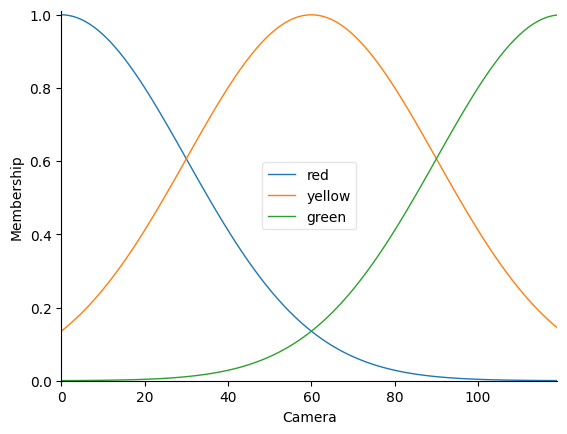

In [75]:
camera.view()

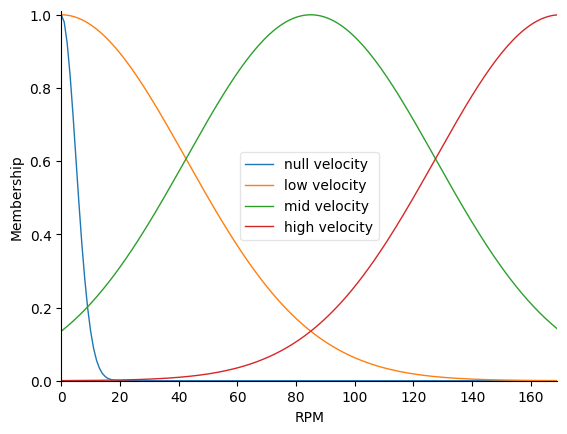

In [76]:
rpm.view()

### Reglas

Las reglas permanecen iguales a las anteriores.

In [77]:
null_red = sk.Rule(encoder['null velocity'] &
                   camera['red'], rpm['null velocity'])
null_yellow = sk.Rule(encoder['null velocity'] &
                      camera['yellow'], rpm['null velocity'])
null_green = sk.Rule(encoder['null velocity'] &
                     camera['green'], rpm['low velocity'])

low_red = sk.Rule(encoder['low velocity'] &
                  camera['red'], rpm['null velocity'])
low_yellow = sk.Rule(encoder['low velocity'] &
                     camera['yellow'], rpm['low velocity'])
low_green = sk.Rule(encoder['low velocity'] &
                    camera['green'], rpm['mid velocity'])

mid_red = sk.Rule(encoder['mid velocity'] &
                  camera['red'], rpm['low velocity'])
mid_yellow = sk.Rule(encoder['mid velocity'] &
                     camera['yellow'], rpm['low velocity'])
mid_green = sk.Rule(encoder['mid velocity'] &
                    camera['green'], rpm['high velocity'])

high_red = sk.Rule(encoder['high velocity'] &
                   camera['red'], rpm['mid velocity'])
high_yellow = sk.Rule(encoder['high velocity'] &
                      camera['yellow'], rpm['mid velocity'])
high_green = sk.Rule(encoder['high velocity'] &
                     camera['green'], rpm['high velocity'])


In [78]:
vel_ctrl = sk.ControlSystem([null_red, null_yellow, null_green, low_red, low_yellow, low_green, mid_red, mid_yellow, mid_green, high_red, high_yellow, high_green]) # The inference blockq
vel = sk.ControlSystemSimulation(vel_ctrl)  # The whole Fuzzy Inference system

Se realizarán las mismas pruebas que las anteriormente descritas

#### Prueba 1

40.30814766794464


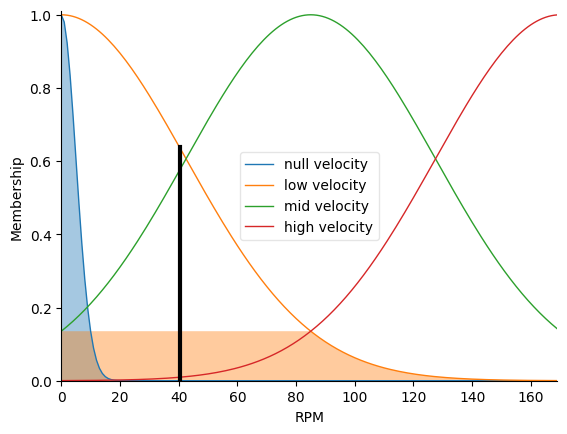

In [79]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 2

40.30246259032406


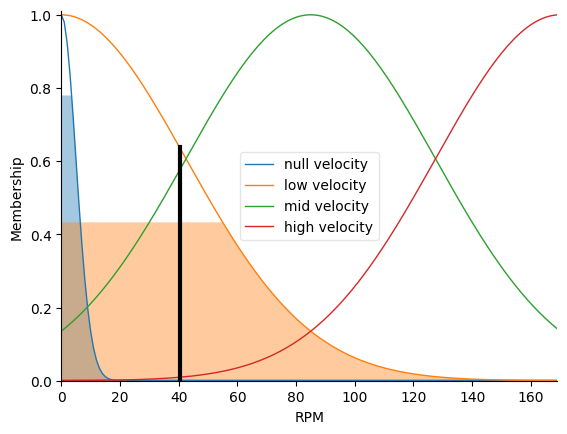

In [80]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 3

51.79544597742482


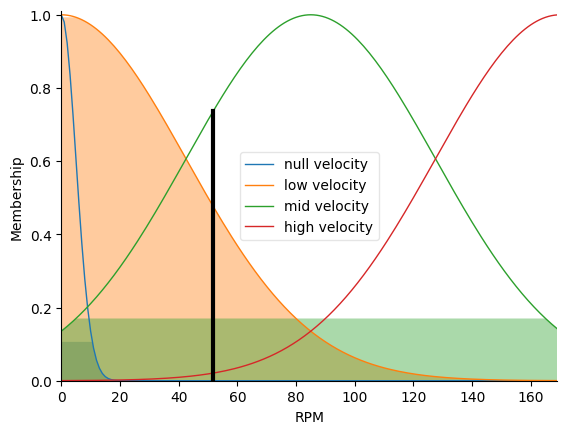

In [81]:
vel.input['Encoder'] = 90
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 4

83.40076591961191


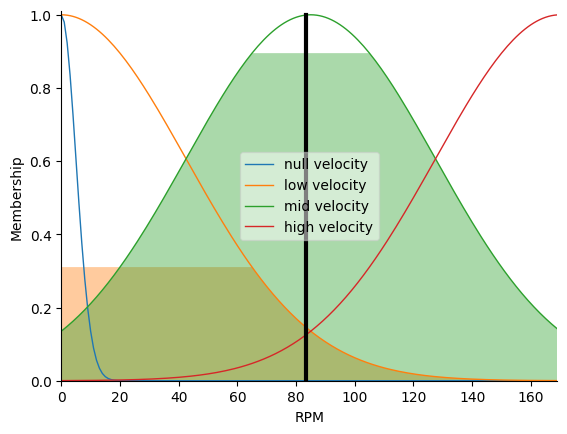

In [82]:
vel.input['Encoder'] = 150
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 5

48.313623084888754


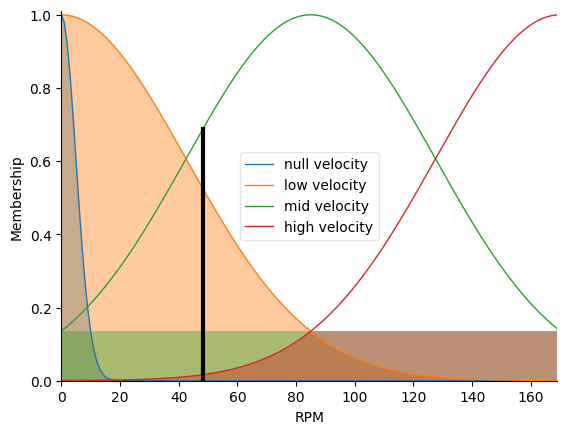

In [83]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 6

51.07915399012969


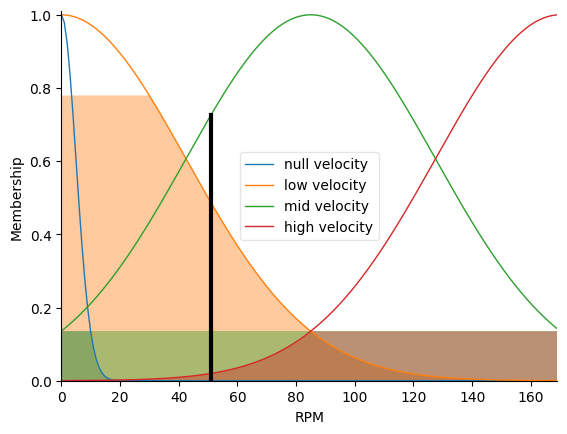

In [84]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 7

51.79544597742482


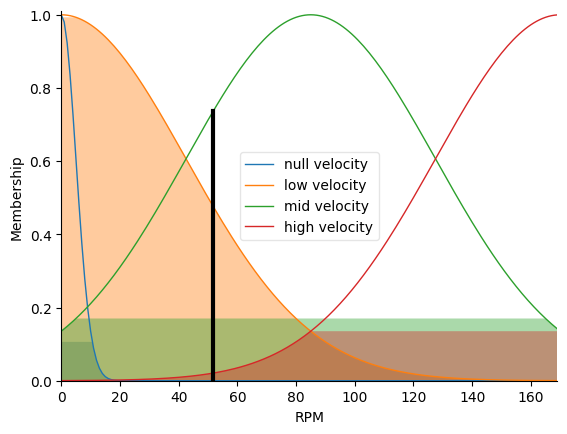

In [85]:
vel.input['Encoder'] = 90
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 8

83.40076591961191


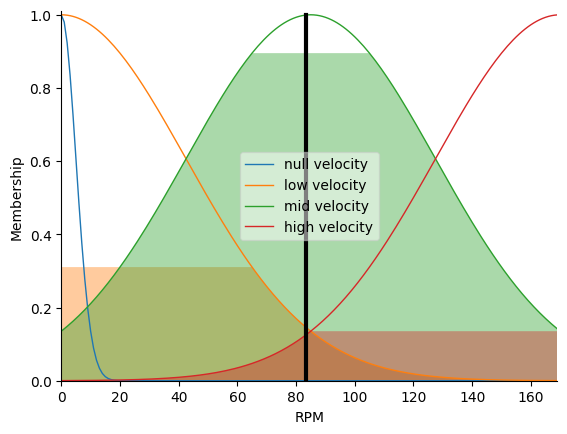

In [86]:
vel.input['Encoder'] = 150
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 9

72.69216191954581


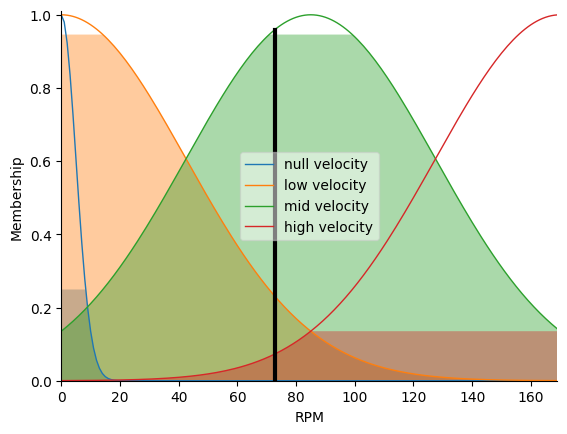

In [87]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 110

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 10

87.69688399299224


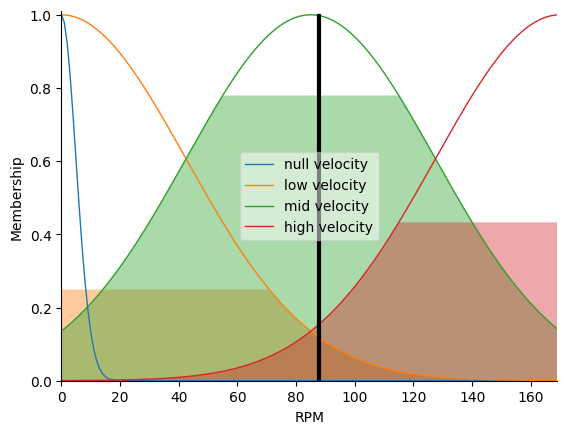

In [88]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 110

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


### Superficie de control

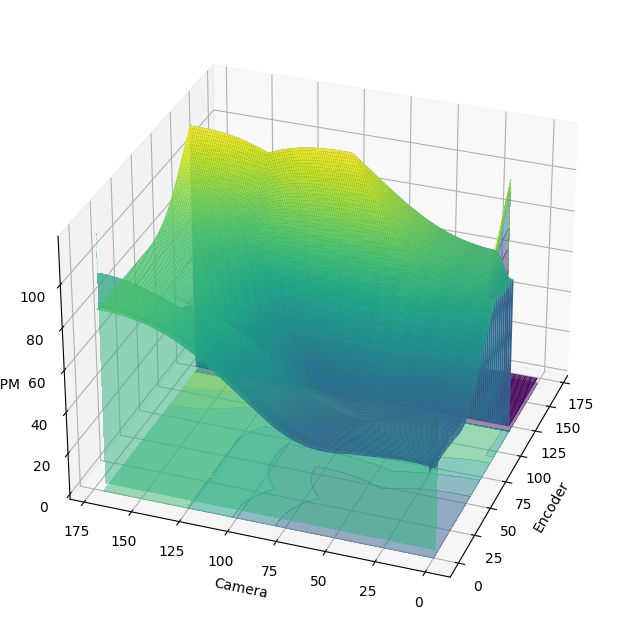

In [89]:
plot_surface(vel)


#### Comparación

En el caso de las funciones de pertenencia gausianas, podemos observar una transición todavía más suave entre los valores. Las tendencias siguen siendo similares, dirigiéndose hacia menores velocidades conforme el color del semáforo se vuelve rojo, pero nunca llegando completamente a cero. Es una mejora comparada con la implementación anterior, pero sigue teniendo áreas de oportunidad.

### Gausiano con desdifusificación de MOM

Como un último controlador, implementaremos el mismo que el anterior, con funciones gausianas, pero esta vez utilizando el método de desdifusificación "Mean of Maximum (MOM)" en lugar del centroide. Esto significa que, a la hora de obtener los resultados de la salida, se obtendrá el promedio del resultado semántico más alto, en lugar del centroide de todos los involucrados. Con esto, intentaremos acercarnos ahora sí a una velocidad nula cuando el semáforo se encuentre en rojo.

In [90]:
rpm = sk.Consequent(np.arange(0, 170, 1), 'RPM', defuzzify_method='mom')
rpm['null velocity'] = fuzz.gaussmf(encoder.universe, 0, 5)
rpm['low velocity'] = fuzz.gaussmf(encoder.universe, 0, 42.5)
rpm['mid velocity'] = fuzz.gaussmf(encoder.universe, 85, 42.5)
rpm['high velocity'] = fuzz.gaussmf(encoder.universe, 170, 42.5)



null_red = sk.Rule(encoder['null velocity'] &
                   camera['red'], rpm['null velocity'])
null_yellow = sk.Rule(encoder['null velocity'] &
                      camera['yellow'], rpm['null velocity'])
null_green = sk.Rule(encoder['null velocity'] &
                     camera['green'], rpm['low velocity'])

low_red = sk.Rule(encoder['low velocity'] &
                  camera['red'], rpm['null velocity'])
low_yellow = sk.Rule(encoder['low velocity'] &
                     camera['yellow'], rpm['low velocity'])
low_green = sk.Rule(encoder['low velocity'] &
                    camera['green'], rpm['mid velocity'])

mid_red = sk.Rule(encoder['mid velocity'] &
                  camera['red'], rpm['low velocity'])
mid_yellow = sk.Rule(encoder['mid velocity'] &
                     camera['yellow'], rpm['low velocity'])
mid_green = sk.Rule(encoder['mid velocity'] &
                    camera['green'], rpm['high velocity'])

high_red = sk.Rule(encoder['high velocity'] &
                   camera['red'], rpm['mid velocity'])
high_yellow = sk.Rule(encoder['high velocity'] &
                      camera['yellow'], rpm['mid velocity'])
high_green = sk.Rule(encoder['high velocity'] &
                     camera['green'], rpm['high velocity'])

vel_ctrl = sk.ControlSystem([null_red, null_yellow, null_green, low_red, low_yellow, low_green,
                            mid_red, mid_yellow, mid_green, high_red, high_yellow, high_green])  # The inference blockq
vel = sk.ControlSystemSimulation(vel_ctrl)  # The whole Fuzzy Inference system


Se realizarán las mismas pruebas que las anteriormente descritas

#### Prueba 1

0.0


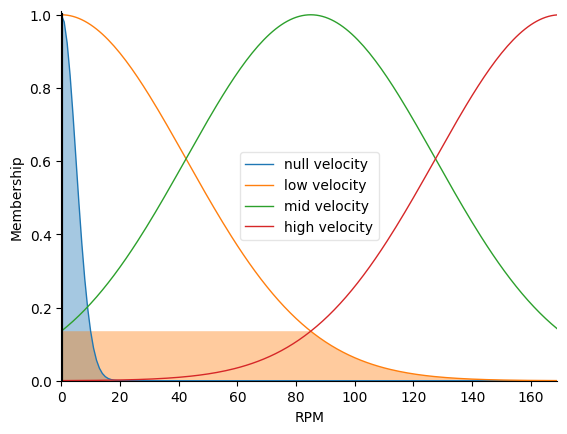

In [91]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 2

1.9022632575225


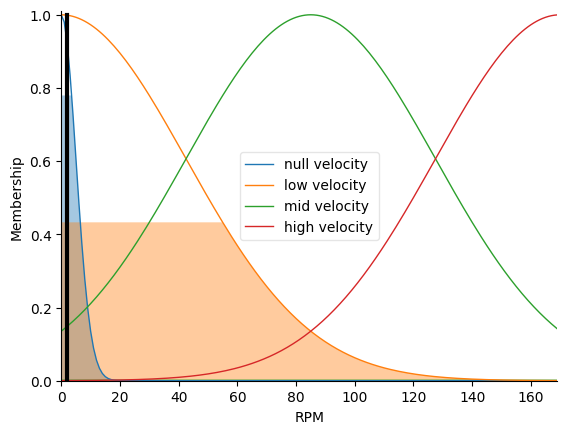

In [92]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 3

2.5


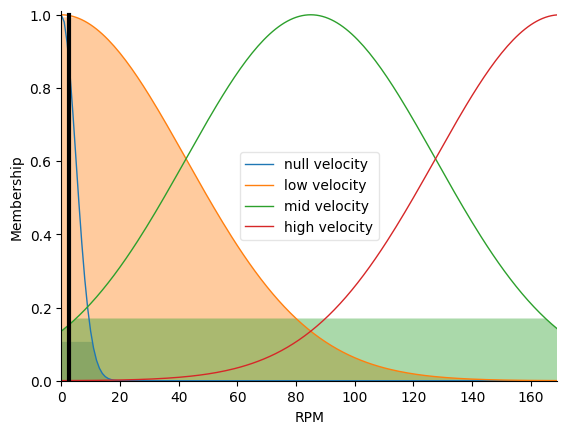

In [93]:
vel.input['Encoder'] = 90
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 4

85.0


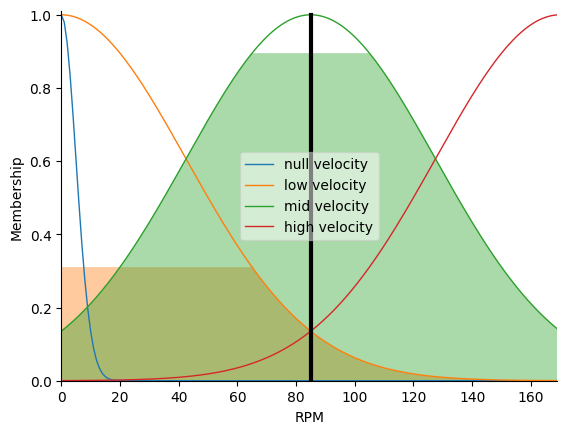

In [94]:
vel.input['Encoder'] = 150
vel.input['Camera'] = 0

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 5

0.0


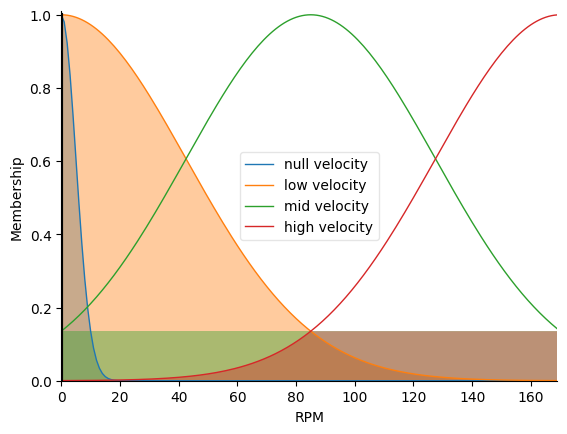

In [95]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 6

15.0


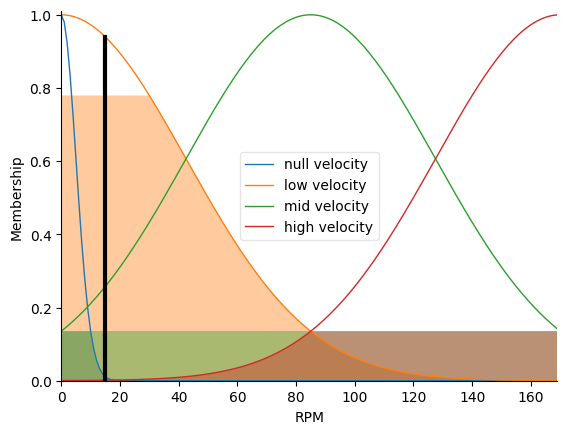

In [96]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 7

2.5


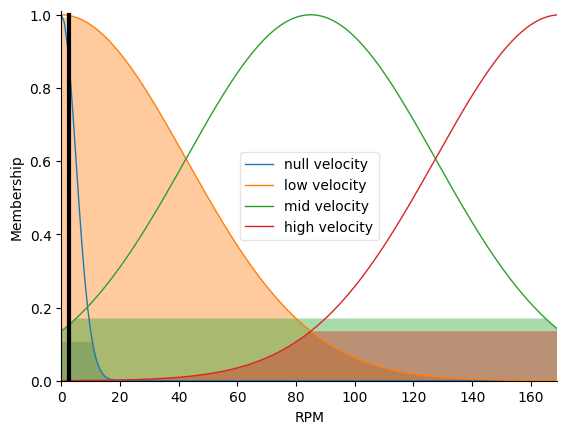

In [97]:
vel.input['Encoder'] = 90
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 8

85.0


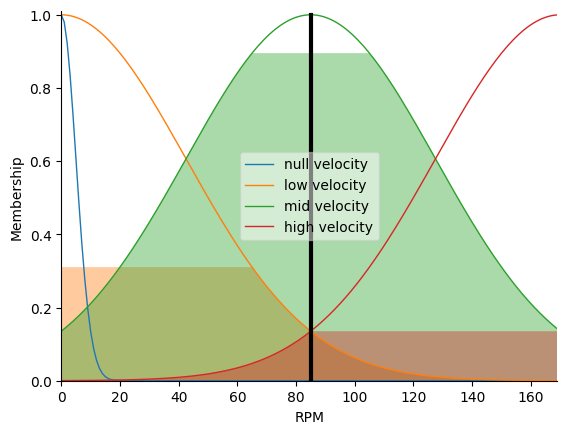

In [98]:
vel.input['Encoder'] = 150
vel.input['Camera'] = 60

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 9

57.5525076241646


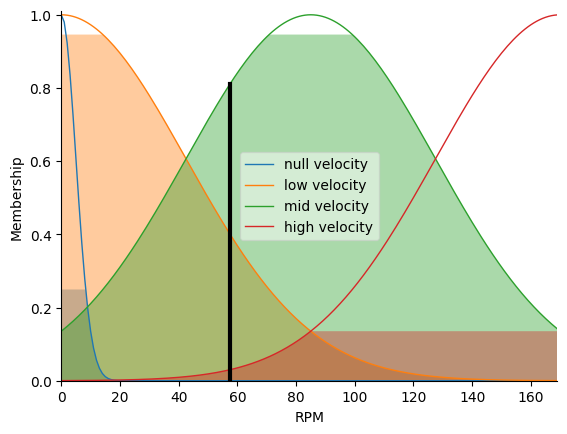

In [99]:
vel.input['Encoder'] = 0
vel.input['Camera'] = 110

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Prueba 10

84.77153322217883


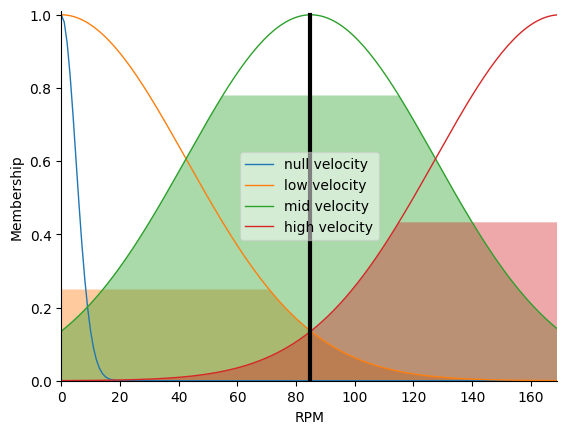

In [100]:
vel.input['Encoder'] = 30
vel.input['Camera'] = 110

# Crunch the numbers
vel.compute()
print(vel.output['RPM'])
rpm.view(sim=vel)


#### Superficie de control

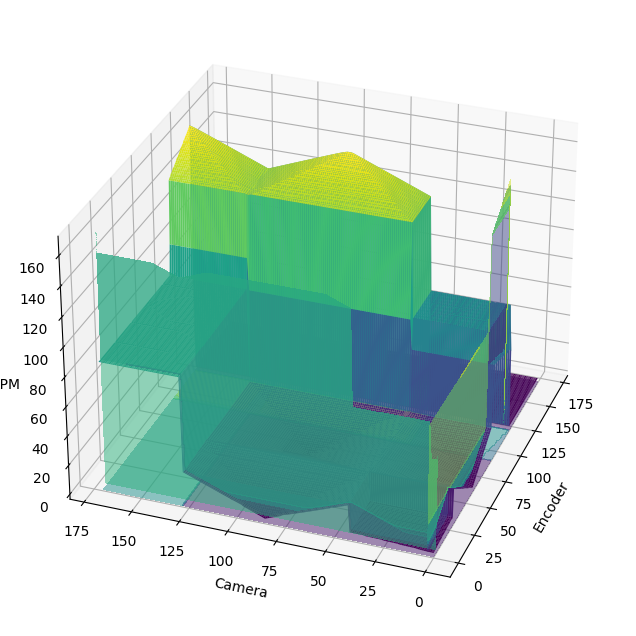

In [101]:
plot_surface(vel)

#### Comparación

Con este último método, tanto en las pruebas como en la superficie de control, podemos ver que, ahora sí, el robot se detiene completamente ante un semáforo rojo, alenta su velocidad en un semáforo amarillo, y va a toda velocidad en un semáforo verde. No obstante, es evidente que esta implementación tiene el problema de que los cambios entre un valor y otro son completamente súbitos, en lugar de suavemente como se logra con el centroide. Esto significaría una mayor dificultad para los motores de seguir las indicaciones del controlador, provocando posiblemente daños, overshoots o resultados incorrectos.

### TSK

Las técnicas utilizadas en los incisos anteriores estuvieron basadas en el método Mamdami, que requiere que las reglas estén compuestas por entradas y salidas difusas. Esto, en ocasiones, requiere de mayor poder computacional, además de que es necesario un paso adicional de desdifusificación para obtener la salida final.

Para solucionar esto, podemos utilizar el modelo TSK. Una de las principales diferencias entre los controladores Mamdani y TSK es la forma en que modelan las reglas difusas. El controlador Mamdani utiliza reglas lingüísticas para describir el comportamiento del sistema, mientras que el controlador TSK utiliza reglas matemáticas precisas. Esto significa que, para cada conjunto de reglas, hay una salida nítida y clara, que no requiere de desdifusificación. Esto permite que el modelo TSK sea más sencillo, menos pesado computacionalmente, más fácil de implementar y más rápido en tiempo de ejecución. 

En general, el controlador TSK se utiliza a menudo en aplicaciones de control en tiempo real donde la velocidad y la simplicidad son importantes, mientras que el controlador Mamdani se utiliza más comúnmente en sistemas de control que implican reglas difusas complejas y una amplia variedad de entradas y salidas.

Para demostrar esto, podemos realizar las siguientes reglas:

In [102]:
import fuzzylite as fl
import math
import plotly.graph_objects as go

engine = fl.Engine(name='Controller',
                   description='Speed controller with traffic light')

#Defining the Input Variables (Fuzzification)
engine.input_variables = [
    fl.InputVariable(
        name='Speed', enabled=True,
        minimum=0.0, maximum=180.0, lock_range=False,
        terms=[
            fl.Triangle('stopped', 0, 0, 5),
            fl.Triangle('slow', 0, 5, 85),
            fl.Triangle('mid', 5, 85, 170),
            fl.Triangle('fast', 85, 170, 170)]),

    fl.InputVariable(
        name='Camera', description="Traffic light HUE", enabled=True,
        minimum=0.0, maximum=120.0, lock_range=False,
        terms=[
            fl.Triangle('red', 0, 0, 60),
            fl.Triangle('yellow', 0, 60, 120),
            fl.Triangle('green', 60, 120, 120)])
]


tsRPM = fl.OutputVariable()
tsRPM.name = "tsRPM"
tsRPM.description = "Wheels RPM based on Takagi-Sugeno inference"
tsRPM.enabled = True
tsRPM.range = (0.000, 170.000)
tsRPM.lock_range = False
tsRPM.aggregation = None
tsRPM.defuzzifier = fl.WeightedAverage("TakagiSugeno")
tsRPM.default_value = fl.nan
tsRPM.lock_previous = False
tsRPM.terms.append(fl.Constant("stopped", 0))
tsRPM.terms.append(fl.Constant("slow", 30))
tsRPM.terms.append(fl.Constant("mid", 100))
tsRPM.terms.append(fl.Constant("fast", 160))
engine.output_variables.append(tsRPM)

takagiSugeno = fl.RuleBlock()
takagiSugeno.name = "takagiSugeno"
takagiSugeno.description = "Takagi-Sugeno inference"
takagiSugeno.enabled = True
takagiSugeno.conjunction = fl.AlgebraicProduct()
takagiSugeno.disjunction = fl.AlgebraicSum()
takagiSugeno.implication = None
takagiSugeno.activation = fl.General()
takagiSugeno.rules = [
    fl.Rule.create("if Speed is stopped and Camera is red then tsRPM is stopped with 0.0", engine),
    fl.Rule.create("if Speed is stopped and Camera is yellow then tsRPM is stopped with 0.0", engine),
    fl.Rule.create("if Speed is stopped and Camera is green then tsRPM is slow with 30.0", engine),
    
    fl.Rule.create("if Speed is slow and Camera is red then tsRPM is stopped with 0.0", engine),
    fl.Rule.create("if Speed is slow and Camera is yellow then tsRPM is slow with 30.0", engine),
    fl.Rule.create("if Speed is slow and Camera is green then tsRPM is fast with 160.0", engine),
    
    fl.Rule.create("if Speed is mid and Camera is red then tsRPM is stopped with 0.0", engine),
    fl.Rule.create("if Speed is mid and Camera is yellow then tsRPM is slow with 30.0", engine),
    fl.Rule.create("if Speed is mid and Camera is green then tsRPM is fast with 160.0", engine),
    
    fl.Rule.create("if Speed is fast and Camera is red then tsRPM is stopped with 0.0", engine),
    fl.Rule.create("if Speed is fast and Camera is yellow then tsRPM is slow with 30.0", engine),
    fl.Rule.create("if Speed is fast and Camera is green then tsRPM is fast with 160.0", engine)
]
    

engine.rule_blocks.append(takagiSugeno)


def getControlSurfaceData(input1Discs, input2Discs, inference_method):
    """Get the data to plot the control surface"""
    incrX = engine.input_variables[0].drange / (input1Discs-1.0)
    incrY = engine.input_variables[1].drange / (input2Discs-1.0)
    x, y, z = [], [], [[0]*input1Discs for i in range(input2Discs)]

    for i in range(input1Discs):
        x.append(i*incrX)
    for i in range(input2Discs):
            y.append(i*incrY)

    for x_ in range(input1Discs):
        engine.input_variables[0].value = fl.scalar(
            x[x_])  # food.setInput(x[x_])
        for y_ in range(input2Discs):
            engine.input_variables[1].value = fl.scalar(
                y[y_])  # service.setInput(y[y_])
            engine.process()
            out = engine.output_variables[0].value
            if out == None or math.isnan(out):
                z[y_][x_] = 0.0
            else:
                z[y_][x_] = out

    fig = go.Figure(data=[go.Surface(z=z)])
    fig.update_layout(title='Control Surface by '+inference_method, autosize=False, scene=dict(
        xaxis_title=engine.input_variables[0].name, yaxis_title=engine.input_variables[1].name, zaxis_title='Speed'),
        width=700, height=500, margin=dict(l=65, r=50, b=65, t=90))
    fig.show()


getControlSurfaceData(170,120, 'tsk')

#### Comparación

Utilizar el método TSK tiene varias ventajas por encima del método Mamdani, como su sencillez, la velocidad de procesamiento y el hecho de que no necesita de desdifusificación. Con esto, podemos tener mucho más control sobre las varialbes de salida, definiendo exactamente qué queremos que haga nuestro robot para cada conjunto de casos. Esto soluciona el problema que presentan los primeros dos métodos, permitiéndonos llegar exactamente a velocidad nula cuando se necesita. 

Podemos observar, por ejemplo, que la superficie de control nos demuestra que, sin importar la velocidad en la que el robot se encuentre, cuando el semáforo está en rojo, el robot se detiene por completo; cuando está en amarillo, tiene una velocidad intermedia; y cuando está en verde, está en la más alta velocidad. 

La diferencia entre este método y el gausiano con MOM, es que es mucho más clara la dirección de las velocidades, y es más sencillo entender el comportamiento del sistema según cada color del semáforo.

## Conclusión

No es tan sencillo seleccionar alguno de los métodos previamente demostrados como el mejor, ya que cada uno tiene sus ventajas y desventajas. Definitivamente, entre el sistema con funciones de pertenencia triangulares y desdifusificación con centroide y el sistema de funciones gausianas y centroide, el segundo se muestra más útil por la suavidad con la que transfiere entre un valor y otro. No obstante, ambos tienen el gran problema de que, a pesar de que tienden correctamente hacia velocidades bajas con el semáforo en rojo y velocidades altas con el semáforo en verde, ninguno de los dos logra detener completamente al robot en ningún momento. Esto, claramente, no es útil para nuestra aplicación que busca que el auto obedezca las leyes de tránsito correctamente. 

En la otra mano, tenemos el controlador con funciones gausianas, pero desdifusificación de MOM. Este método tiene la gran ventaja de que logra el cometido de seguir las reglas al pie de la letra, deteniendo el robot por completo cuando se presenta un semáforo rojo, y alcanzando la mayor velocidad posible en el semáforo verde. Sin embargo, tiene una evidente área de oportunidad en la suavidad de su transferencia entre valores. Dada la naturaleza del algoritmo de desdifusificación utilizado, las transferencias entre una variable semántica con la siguiente son muy abruptas, yendo de promedio en promedio en lugar de fluyendo con suavidad. 

Por último, tenemos el controlador de tipo TSK. Este último controlador utiliza salidas nítidas en lugar de ofuscadas, por lo que es mucho más claro, tanto para nosotros como para el robot, qué es lo que se debe hacer en cada color del semáforo. Con este controlador, podemos llegar a una velocidad nula, baja, media y alta con bastante facilidad, según sea el caso acorde al color. 

Para poder implementar un controlador difuso de este tipo, sería necesario encontrar una manera donde se puedan juntar todos los resultados para obtener una transferencia suave entre valores, pero con tendencia hacia un cero absoluto, en lugar de solamente valores bajos. 
